In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adagrad


In [2]:
df=pd.read_csv("./data/energydata_complete.csv")

In [3]:
df.head()

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,...,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
1,2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,...,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2,2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,...,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668
3,2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,...,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389
4,2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,...,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097


In [4]:
df.columns

Index(['date', 'Appliances', 'lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3',
       'RH_3', 'T4', 'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8',
       'RH_8', 'T9', 'RH_9', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed',
       'Visibility', 'Tdewpoint', 'rv1', 'rv2'],
      dtype='object')

Explained variables: energy consumption ("Appliances" and "lights")

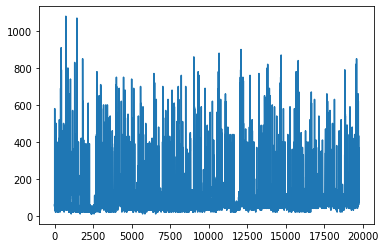

In [5]:
plt.plot(df["Appliances"])
plt.show()

Introduce past consumption data?


NSM: time from midnight each day, in seconds

Day of the week, working day or holiday

In [6]:
df["NSM"]=df["date"].apply(lambda x:datetime.datetime.strptime(x,"%Y-%m-%d %H:%M:%S").timestamp()
-datetime.datetime.strptime(x,"%Y-%m-%d %H:%M:%S").replace(hour=0,minute=0,second=0).timestamp())

In [7]:
day=df["date"].apply(lambda x:datetime.datetime.strptime(x,"%Y-%m-%d %H:%M:%S").weekday())
df=df.merge(pd.get_dummies(day),left_index=True,right_index=True)


In [8]:
days_columns=df.columns[-7:]

In [9]:
df["week-end"]=day.apply(lambda x: x in [5,6]) # à checker

# Feature selection 

The explained variable is the total energy consumption ("Appliances")

The paper proposes two feature selection algorithms.
<ul>
    <li> Boruta algorithm
    <li> Recursive Forrest Elimination
<ul>


In [10]:
y=df[["Appliances"]]
# lights considered as an explanatory variable
X=df.iloc[:,[x not in ["Appliances"] for x in df.columns]]

In [11]:
print(X.shape)
print(y.shape)

(19735, 37)
(19735, 1)


In [12]:
X.describe()

,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,...,rv1,rv2,NSM,0,1,2,3,4,5,6
count,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,...,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000
mean,3.801875,21.686571,40.259739,20.341219,40.420420,22.267611,39.242500,20.855335,39.026904,19.592106,...,24.988033,24.988033,42884.144920,0.140765,0.145934,0.145934,0.145934,0.144160,0.138637,0.138637
std,7.935988,1.606066,3.979299,2.192974,4.069813,2.006111,3.254576,2.042884,4.341321,1.844623,...,14.496634,14.496634,24936.698686,0.347788,0.353049,0.353049,0.353049,0.351261,0.345576,0.345576
min,0.000000,16.790000,27.023333,16.100000,20.463333,17.200000,28.766667,15.100000,27.660000,15.330000,...,0.005322,0.005322,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,20.760000,37.333333,18.790000,37.900000,20.790000,36.900000,19.530000,35.530000,18.277500,...,12.497889,12.497889,21000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,21.600000,39.656667,20.000000,40.500000,22.100000,38.530000,20.666667,38.400000,19.390000,...,24.897653,24.897653,42600.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,22.600000,43.066667,21.500000,43.260000,23.290000,41.760000,22.100000,42.156667,20.619643,...,37.583769,37.583769,64200.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,70.000000,26.260000,63.360000,29.856667,56.026667,29.236000,50.163333,26.200000,51.090000,25.795000,...,49.996530,49.996530,85800.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [13]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25)

In [14]:
feature_selection=["T_out","Press_mm_hg","RH_out","Windspeed","Tdewpoint","NSM","week-end"]+list(days_columns)

### Creation of three subsets 

In [15]:
x=X[feature_selection]
y=y

In [16]:
x_tr=X_train[feature_selection]
y_tr=y_train

In [17]:
x_tt=X_test[feature_selection]
y_tt=y_test

In [18]:
def scale(X):
    scaler=StandardScaler()
    categorical_feature=["week-end"]+list(range(7))
    other_feature=["date"]
    numerical_feature=[f for f in X.columns if f not in categorical_feature+other_feature]
    x_cat=np.array(X[categorical_feature])
    x_num=scaler.fit_transform(X[numerical_feature])
    return np.concatenate((x_num,x_cat),axis=1)

In [19]:
x=scale(x)
x_tr=scale(x_tr)
x_tt=scale(x_tt)

# Model fitting 

In [20]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR #Radial kernel

In [21]:
from sklearn.model_selection import GridSearchCV

gs_params={"n_jobs":-1,"cv":3,"verbose":True}

In [22]:
gb_params={"learning_rate":[0.1,0.01],"n_estimators":[10,100,200]}

In [23]:
reg_gb=GridSearchCV(GradientBoostingRegressor(),param_grid=gb_params,**gs_params)

In [24]:
reg_gb.fit(x_tr,y_tr)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:   11.5s finished
/home/default/.local/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=GradientBoostingRegressor(alpha=0.9,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100,
                                                 n_iter_no_change=None,
                

In [25]:
best_reg_gb=reg_gb.best_estimator_

In [26]:
reg_gb.best_params_

{'learning_rate': 0.1, 'n_estimators': 200}

Paper: number of estimators 10900 and maximum tree depth 5. Clear overfitting..

In [27]:
reg_gbm=GradientBoostingRegressor(n_estimators=10900,max_depth=5)
reg_gbm.fit(x_tr,y_tr)

/home/default/.local/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=5,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=10900,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [28]:
print("training %.4f"%(reg_gbm.score(x_tr,y_tr)))

print("testing %.4f"%(reg_gbm.score(x_tt,y_tt)))


training 0.9999
testing 0.3460


In [29]:
best_reg_gb.score(x_tr,y_tr)

0.34985778854205696

In [30]:
best_reg_gb.score(x_tt,y_tt)

0.2570816623046067

## MLP 

### Dataset  & Dataloaders

In [31]:
class AppliancesConsumptionDataset(Dataset):
    def __init__(self,X,y):
        super(AppliancesConsumptionDataset,self).__init__()
        if isinstance(X,pd.DataFrame):
            X=torch.tensor(X.values.astype("float32"))
            y=torch.tensor(y.values.astype("float32"))
        self.X=X
        self.y=y
    def __getitem__(self,i):
        return self.X[i,:],self.y[i]
    def __len__(self):
        return len(self.y)

### MLP class definition

In [32]:
class MLP(torch.nn.Module):
    def __init__(self,layers=[10,1]):
        super(MLP,self).__init__()
        self.layers=layers
        
        f=torch.nn.Linear(layers[0],layers[1])
        for i in range(1,len(layers)-1):
            f=torch.nn.Sequential(f,torch.nn.Linear(layers[i],layers[i+1]))
        self.f=f
        self.activation=torch.nn.ReLU()
        
    def forward(self,x):
        return self.activation(self.f(x))

### Training 

In [33]:
def train(X,y,hidden_layers=[10],epochs=100):
    dataset=AppliancesConsumptionDataset(X,y)
    dataloader=DataLoader(dataset,batch_size=128,shuffle=True)
    layers=[X.shape[1]]+hidden_layers+[1]
    model=MLP(layers)
    optimizer=Adagrad(params=model.parameters(),lr=1e-2)
    loss_func=torch.nn.MSELoss()
    loss_history=[]
    for epoch in range(epochs):
        for X,y in dataloader:
            optimizer.zero_grad()
            y_pred=model.forward(X)
            loss=loss_func(y_pred,y)
            loss_history.append(loss)
            loss.backward()
            optimizer.step()
        if epoch %(epochs//10)==0:
            print("Epoch %d"%(epoch))
    return model,loss_history

In [34]:
nn_model,loss_history=train(X[feature_selection],y)

Epoch 0
Epoch 10
Epoch 20
Epoch 30
Epoch 40
Epoch 50
Epoch 60
Epoch 70
Epoch 80
Epoch 90


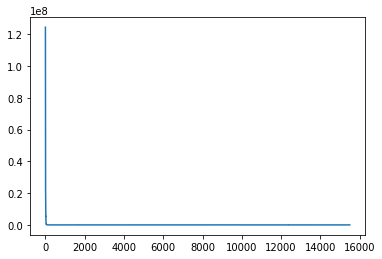

In [35]:
plt.plot(loss_history)

In [36]:
X_nn=torch.tensor(X[feature_selection].values.astype("float32"))
y_nn=torch.tensor(y.values.astype("float32"))

In [37]:
def score(model,X,y,return_results=False):
    y_pred=model.forward(X)
    rmse=torch.mean((y-y_pred)**2)**0.5
    print("RMSE %.2f"%(rmse))
    y_mean=torch.mean(y)
    rsquared=1-(torch.sum((y-y_pred)**2)/torch.sum((y-y_mean)**2))
    print("R2 %.2f"%(rsquared))
    mae=torch.mean(torch.abs(y-y_pred))
    print("MAE %.2f"%(mae))
    mape=torch.mean(torch.abs(y-y_pred)/y)
    print("MAPE %.2f"%(mape))
    if return_results:
        return rmse,rsquared,mae,mape
    

In [38]:
score(nn_model,X_nn,y_nn)

RMSE 114.69
R2 -0.25
MAE 74.05
MAPE 0.89
